<a href="https://www.kaggle.com/code/redwackyferret/yipee?scriptVersionId=92897823" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install einops

In [3]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn


In [4]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        self.af1 = nn.GELU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hidden_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std = 1e-6)
        self.do2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)
        
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5  # 1/sqrt(dim)

        self.to_qkv = nn.Linear(dim, dim * 3, bias = True) # Wq,Wk,Wv for each vector, thats why *3
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)
        
        self.nn1 = nn.Linear(dim, dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)        
        self.do1 = nn.Dropout(dropout)
        

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x) #gets q = Q = Wq matmul x1, k = Wk mm x2, v = Wv mm x3
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv = 3, h = h) # split into multi head attentions

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1) #follow the softmax,q,d,v equation in the paper

        out = torch.einsum('bhij,bhjd->bhid', attn, v) #product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)') #concat heads into one matrix, ready for next encoder block
        out =  self.nn1(out)
        out = self.do1(out)
        return out


In [5]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads = heads, dropout = dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attention, mlp in self.layers:
            x = attention(x, mask = mask) # go to attention
            x = mlp(x) #go to MLP_Block
        return x

In [6]:
class ImageTransformer(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 1, dropout = 0.1, emb_dropout = 0.1):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2  # e.g. (32/4)**2= 64
        patch_dim = channels * patch_size ** 2  # e.g. 3*8**2 = 64*3

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.empty(1, (num_patches + 1), dim))
        torch.nn.init.normal_(self.pos_embedding, std = .02) # initialized based on the paper
        self.patch_conv= nn.Conv2d(1,dim, patch_size, stride = patch_size) #eqivalent to x matmul E, E= embedd matrix, this is the linear patch projection
        
        #self.E = nn.Parameter(nn.init.normal_(torch.empty(BATCH_SIZE_TRAIN,patch_dim,dim)),requires_grad = True)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim)) #initialized based on the paper
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.nn1 = nn.Linear(dim, num_classes)  # if finetuning, just use a linear layer without further hidden layers (paper)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        # self.af1 = nn.GELU() # use additinal hidden layers only when training on large datasets
        # self.do1 = nn.Dropout(dropout)
        # self.nn2 = nn.Linear(mlp_dim, num_classes)
        # torch.nn.init.xavier_uniform_(self.nn2.weight)
        # torch.nn.init.normal_(self.nn2.bias)
        # self.do2 = nn.Dropout(dropout)

    def forward(self, img, mask = None):
        p = self.patch_size

        x = self.patch_conv(img) # each of 64 vecotrs is linearly transformed with a FFN equiv to E matmul
        #x = torch.matmul(x, self.E)
        x = rearrange(x, 'b c h w -> b (h w) c') # 64 vectors in rows representing 64 patches, each 64*3 long

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x, mask) #main game

        x = self.to_cls_token(x[:, 0])
        
        x = self.nn1(x)
        # x = self.af1(x)
        # x = self.do1(x)
        # x = self.nn2(x)
        # x = self.do2(x)
        
        return x

In [7]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100

In [8]:
DL_PATH = "C:\Pytorch\Spyder\CIFAR10_data"
MNIST_PATH = "C:\Pytorch\Spyder\MNIST"
# MNIST: 600000 28*28 color images in 10 classes, with 6000 images per class 
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class


In [9]:
transform = torchvision.transforms.Compose(
     [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
     torchvision.transforms.RandomAffine(8, translate=(.15,.15)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.5], [0.5])])


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [10]:
#CIFAR_10
# train_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=True,
#                                         download=True, transform=transform)

# test_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=False,
#                                        download=True, transform=transform)
#MNIST
train_dataset = torchvision.datasets.MNIST(MNIST_PATH, train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(MNIST_PATH, train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,
                                         shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting C:\Pytorch\Spyder\MNIST/MNIST/raw/train-images-idx3-ubyte.gz to C:\Pytorch\Spyder\MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting C:\Pytorch\Spyder\MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Pytorch\Spyder\MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting C:\Pytorch\Spyder\MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Pytorch\Spyder\MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting C:\Pytorch\Spyder\MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Pytorch\Spyder\MNIST/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
# make a dictionary for creating the graph
epochvsloss = {}
epochvsaccu = {}

In [12]:
def train(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
            
def evaluate(model, data_loader, loss_history, idx):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    epochvsloss[idx] = avg_loss
    x = (correct_samples / total_samples)
    
    epochvsaccu[idx] = x.item()
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [13]:
N_EPOCHS = 50

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
# image_size = 32 for CIFAR_10, 28 for MNIST
model = ImageTransformer(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
# ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
#             dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


train_loss_history, test_loss_history = [], []
idx = 0
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    idx += 1
    evaluate(model, test_loader, test_loss_history, idx)
    
print('Execution time')

# PATH = "..\ViTnet_Cifar10_4x4_aug_1.pt" # Use your own path


Epoch: 1
[    0/60000 (  0%)]  Loss: 4.3768
[10000/60000 ( 17%)]  Loss: 2.1294
[20000/60000 ( 33%)]  Loss: 1.6292
[30000/60000 ( 50%)]  Loss: 1.6257
[40000/60000 ( 67%)]  Loss: 1.3544
[50000/60000 ( 83%)]  Loss: 1.1653
Execution time: 85.04 seconds

Average test loss: 0.8691  Accuracy: 6841/10000 (68.41%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.8087
[10000/60000 ( 17%)]  Loss: 1.0378
[20000/60000 ( 33%)]  Loss: 0.7667
[30000/60000 ( 50%)]  Loss: 0.7947
[40000/60000 ( 67%)]  Loss: 0.5989
[50000/60000 ( 83%)]  Loss: 0.5216
Execution time: 83.35 seconds

Average test loss: 0.5819  Accuracy: 7924/10000 (79.24%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.7700
[10000/60000 ( 17%)]  Loss: 0.5056
[20000/60000 ( 33%)]  Loss: 0.5310
[30000/60000 ( 50%)]  Loss: 0.5977
[40000/60000 ( 67%)]  Loss: 0.6523
[50000/60000 ( 83%)]  Loss: 0.6276
Execution time: 83.30 seconds

Average test loss: 0.3742  Accuracy: 8682/10000 (86.82%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.6685
[10000/60000 ( 17%)]  Loss: 0.56

In [16]:
# print(test_loss_history)
print(epochvsloss)

print(epochvsaccu)

{1: 0.8690952152252197, 2: 0.5818640384674072, 3: 0.3741721580505371, 4: 0.3721035569667816, 5: 0.34251875433921813, 6: 0.3126149692058563, 7: 0.25696507196426394, 8: 0.2496556131362915, 9: 0.24203115980625153, 10: 0.2331247515141964, 11: 0.19671150736808776, 12: 0.20280021525621414, 13: 0.17554679104685783, 14: 0.1604194358766079, 15: 0.1515602061331272, 16: 0.1541913709819317, 17: 0.17414212868213655, 18: 0.13243384746313094, 19: 0.12563364078998565, 20: 0.12819500068575143, 21: 0.1153192996263504, 22: 0.1195624818623066, 23: 0.11923632454574108, 24: 0.10713095849305392, 25: 0.12190784269720316, 26: 0.12306049448922277, 27: 0.1054411145567894, 28: 0.11171710981018841, 29: 0.103939120618999, 30: 0.10768758746907114, 31: 0.10323998047970236, 32: 0.10496330706365406, 33: 0.09144228315763175, 34: 0.092932446885854, 35: 0.1029283907983452, 36: 0.08885126370377838, 37: 0.10339311554990709, 38: 0.08494661618247629, 39: 0.09048382314182818, 40: 0.08542050271555782, 41: 0.0950792848173529, 42

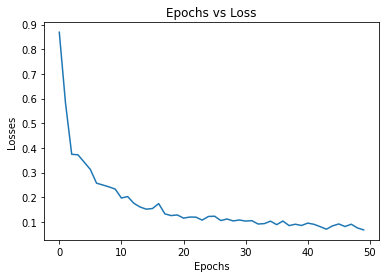

In [17]:
my_df = pd.DataFrame(epochvsloss.values())
ax = sns.lineplot( data = my_df, color="red")
ax.set(xlabel = "Epochs", ylabel = "Losses",  title = "Epochs vs Loss")
ax.legend_.remove()
# sns.set(rc={'figure.figsize':(13,9)})
plt.savefig("loss.png")

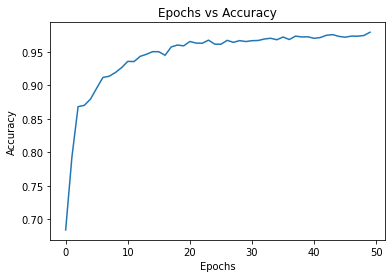

In [18]:
my_df = pd.DataFrame(epochvsaccu.values())
ax = sns.lineplot( data = my_df, color='r')
ax.set(xlabel = "Epochs", ylabel = "Accuracy", title = "Epochs vs Accuracy")
ax.legend_.remove()
sns.set(rc={'figure.figsize':(13,9)})
plt.savefig("accu.png")

In [19]:
PATH = "mnist_model.pth"
torch.save(model.state_dict(), PATH)


In [20]:
# weight of size [64, 3, 7, 7], expected input[100, 1, 28, 28] to have 3 channels, but got 1 channels instead